# 3D ResNet

Basic + Augmentations (invert, rotate, zoom, blur, noise) + Batch Norm + Dropout + l2

In [1]:
%load_ext autoreload
%autoreload 2

import sys
sys.path.append('../..')

import datetime
import os
os.environ["CUDA_VISIBLE_DEVICES"]="1"

import numpy as np

from src.data import train_test_split, MRISequence
from src.model import create_model, compile_model, load_checkpoint
from src.model.training import train
from src.model.evaluation import plot_training_history, show_simple_metrics, show_metrics

In [2]:
import tensorflow as tf

RANDOM_SEED = 300785674475887
tf.random.set_seed(RANDOM_SEED)

print(tf.version.VERSION)
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

2.3.1
Num GPUs Available:  1


## Setup

In [3]:
%%time

ROOT_DIR = '../../tmp'
DEFAULT_CHECKPOINT_DIRECTORY_LOCAL = os.path.join(ROOT_DIR, 'checkpoints')
DEFAULT_BCKP_CHECKPOINT_DIRECTORY_LOCAL = os.path.join(ROOT_DIR, 'bckp-checkpoints')

LOG_DIRECTORY = os.path.join(ROOT_DIR, 'logs')
CHECKPOINT_DIRECTORY = DEFAULT_CHECKPOINT_DIRECTORY_LOCAL

LOG_DIRECTORY_LOCAL = LOG_DIRECTORY
CHECKPOINT_DIRECTORY_LOCAL = CHECKPOINT_DIRECTORY

DATA_DIR_NAME = 'data-v3'
DATA_DIR = os.path.join(ROOT_DIR, DATA_DIR_NAME)

saliencies_and_segmentations_v2_path = os.path.join(ROOT_DIR, 'saliencies_and_segmentations_v2')

if not os.path.exists(CHECKPOINT_DIRECTORY):
    os.mkdir(CHECKPOINT_DIRECTORY)

if not os.path.exists(LOG_DIRECTORY):
    os.mkdir(LOG_DIRECTORY)

val = False
    
class_names = ['AD', 'CN']

# get paths to data
train_dir, test_dir, val_dir = train_test_split(
    saliencies_and_segmentations_v2_path, 
    ROOT_DIR, 
    split=(0.8, 0.15, 0.05), 
    dirname=DATA_DIR_NAME)

# set the batch size for mri seq
batch_size = 12
input_shape = (104, 128, 104, 1) # (112, 112, 105, 1)
resize_img = True
crop_img = True

# if y is one-hot encoded or just scalar number
one_hot = True

# class weights (see analysis notebook)
class_weights = {0: 0.8072289156626505, 1: 1.3137254901960784}

# description statistics of the dataset
desc = {'mean': -3.6344006e-09, 'std': 1.0000092, 'min': -1.4982183, 'max': 10.744175}

if 'desc' not in locals():
    print('initializing desc...')
    desc = get_description(MRISequence(
        train_dir,
        64,
        class_names=class_names,
        input_shape=input_shape),
        max_samples=None)
    print(desc)


normalization={ 'type':'normalization', 'desc': desc }
# normalization={'type':'standardization', 'desc':desc }

augmentations = None
augmentations_inplace = True
# enable augmentations in mri seq (otherwise it can be enabled in dataset)
# augmentations={ 'random_swap_hemispheres': 0.5 }

# initialize sequences
print('initializing train_seq...')
train_seq = MRISequence(
    train_dir,
    batch_size,
    class_names=class_names,
    augmentations=augmentations,
    augmentations_inplace=augmentations_inplace,
    input_shape=input_shape,
    resize_img=resize_img,
    crop_img=crop_img,
    one_hot=one_hot,
    class_weights=class_weights,
    normalization=normalization)

print('initializing test_seq...')
test_seq = MRISequence(
    test_dir,
    batch_size,
    class_names=class_names,
    input_shape=input_shape,
    resize_img=resize_img,
    crop_img=crop_img,
    one_hot=one_hot,
    normalization=normalization)

if val:
    print('initializing val_seq...')
    val_seq = MRISequence(
        val_dir,
        batch_size,
        class_names=class_names,
        input_shape=input_shape,
        resize_img=resize_img,
        crop_img=crop_img,
        one_hot=one_hot,
        class_weights=class_weights,
        normalization=normalization)
else:
    print('val_seq = test_seq')
    val_seq = test_seq
    
model_key = datetime.datetime.now().strftime('%Y%m%d-%H%M%S')
log_dir = os.path.join(LOG_DIRECTORY, model_key)
print(f'log_dir: {log_dir}')

not copying files since the destination directory already exists
initializing train_seq...
initializing test_seq...
val_seq = test_seq
log_dir: ../../tmp\logs\20201229-171741
Wall time: 6 ms


In [4]:
# https://www.tensorflow.org/tutorials/structured_data/imbalanced_data#class_weights
# pos / neg
initial_bias = np.log([159/243, 243/159])

model_type = 'ResNet18'
model_config = {
    'input_shape': input_shape,
    'class_names': class_names,
#     'l2_beta': 0.001,
    'l2_beta': 0.00025,
#     'l2_beta': None,
    'dropout': 0.35,
#     'dropout': None,
    'output_bias': initial_bias,
    'batch_norm': True,
#     'output_bias': None,
    # https://www.tensorflow.org/api_docs/python/tf/keras/layers/BatchNormalization
}

compile_config = {
    # default is 0.001
#     'learning_rate': 0.000075,
    'learning_rate': 0.00015,
    'decay_steps': 25,
    'decay_rate': 0.96,
#     'beta_1': 0.85,
    'beta_1': 0.90,
#     'beta_2': 0.990,
    'beta_2': 0.999,
}

train_config = {
    'model_key': model_key,
    'epochs': 200,
    'patience': 30,
    'tensorboard_update_freq': 'epoch',
    'mri_tensorboard_callback': False,
    'model_checkpoint_callback': {'monitor': 'val_categorical_accuracy', 'mode': 'max', 'save_best_only': True},
    'early_stopping_monitor': {'monitor': 'val_categorical_accuracy', 'mode': 'max'},
    'augmentations': {
        'invert': (0.5, None),
        'rotate': (0.2, 5), # probability, degrees
        'zoom': (0.2, 0.20),
        'shear': (0, 0), # probability, degrees
        'blur': (0.2, 0.85),
        'noise': (0.2, 0.00020)
    },
#     'augmentations': False,
    'batch_size': 10,
#     'model_checkpoint_callback': False,
}

## Train

In [5]:
model = create_model(model_type, model_config)
model, *_ = compile_model(model, **compile_config)
model.build(input_shape=input_shape)
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape (Reshape)            (None, 104, 128, 104)     0         
_________________________________________________________________
my_res_net (MyResNet)        (None, 512)               11770304  
_________________________________________________________________
dropout (Dropout)            (None, 512)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 256)               131328    
_________________________________________________________________
dropout_1 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 128)               32896     
_________________________________________________________________
dropout_2 (Dropout)          (None, 128)               0

In [6]:
# load_checkpoint(model, DEFAULT_CHECKPOINT_DIRECTORY_LOCAL, '20201213-182225', 'cp-0002.ckpt')

In [7]:
from tensorflow.python.client import device_lib

def get_available_gpus():
    local_device_protos = device_lib.list_local_devices()
    return [x.name for x in local_device_protos if x.device_type == 'GPU']

print(get_available_gpus())

['/device:GPU:0']


In [8]:
%%time

model, checkpoint_dir, history = train(
    model,
    train_seq,
    test_seq,
    CHECKPOINT_DIRECTORY,
    LOG_DIRECTORY,
    DATA_DIR,
    **train_config
)

model key: 20201229-171741
checkpoint dir: ../../tmp\checkpoints\20201229-171741
log dir: ../../tmp\logs\20201229-171741
loading ../../tmp\data-v3\train_x.npy, ../../tmp\data-v3\train_y.npy...
loading ../../tmp\data-v3\val_x.npy, ../../tmp\data-v3\val_y.npy...
training...
Epoch 1/200
41/41 [==============================] - ETA: 0s - loss: 2.0238 - recall: 0.4726 - precision: 0.4726 - auc: 0.4496 - categorical_accuracy: 0.4726
Epoch 00001: val_categorical_accuracy improved from -inf to 0.38000, saving model to ../../tmp\checkpoints\20201229-171741\cp-0001.ckpt
41/41 [==============================] - 7s 162ms/step - loss: 2.0238 - recall: 0.4726 - precision: 0.4726 - auc: 0.4496 - categorical_accuracy: 0.4726 - val_loss: 1.9271 - val_recall: 0.3800 - val_precision: 0.3800 - val_auc: 0.3708 - val_categorical_accuracy: 0.3800
Epoch 2/200
41/41 [==============================] - ETA: 0s - loss: 1.9645 - recall: 0.5075 - precision: 0.5075 - auc: 0.4999 - categorical_accuracy: 0.5075
Epoch 

Epoch 32/200
40/41 [============================>.] - ETA: 0s - loss: 1.2624 - recall: 0.9325 - precision: 0.9325 - auc: 0.9870 - categorical_accuracy: 0.9325- ETA: 2s - loss: 1.2398 - recall: 0.9312 - precision: 0.9312 - auc: 0.9877 - categor
Epoch 00032: val_categorical_accuracy did not improve from 0.78000
41/41 [==============================] - 5s 126ms/step - loss: 1.2631 - recall: 0.9303 - precision: 0.9303 - auc: 0.9868 - categorical_accuracy: 0.9303 - val_loss: 1.9322 - val_recall: 0.7800 - val_precision: 0.7800 - val_auc: 0.8280 - val_categorical_accuracy: 0.7800
Epoch 33/200
41/41 [==============================] - ETA: 0s - loss: 1.2773 - recall: 0.9328 - precision: 0.9328 - auc: 0.9849 - categorical_accuracy: 0.9328
Epoch 00033: val_categorical_accuracy did not improve from 0.78000
41/41 [==============================] - 5s 122ms/step - loss: 1.2773 - recall: 0.9328 - precision: 0.9328 - auc: 0.9849 - categorical_accuracy: 0.9328 - val_loss: 1.9115 - val_recall: 0.7400 - 

Epoch 48/200
39/41 [===========================>..] - ETA: 0s - loss: 1.2008 - recall: 0.9692 - precision: 0.9692 - auc: 0.9964 - categorical_accuracy: 0.9692
Epoch 00048: val_categorical_accuracy did not improve from 0.79000
41/41 [==============================] - 5s 127ms/step - loss: 1.2006 - recall: 0.9701 - precision: 0.9701 - auc: 0.9965 - categorical_accuracy: 0.9701 - val_loss: 2.0156 - val_recall: 0.7600 - val_precision: 0.7600 - val_auc: 0.8068 - val_categorical_accuracy: 0.7600
Epoch 49/200
40/41 [============================>.] - ETA: 0s - loss: 1.2216 - recall: 0.9475 - precision: 0.9475 - auc: 0.9925 - categorical_accuracy: 0.9475
Epoch 00049: val_categorical_accuracy did not improve from 0.79000
41/41 [==============================] - 5s 114ms/step - loss: 1.2211 - recall: 0.9478 - precision: 0.9478 - auc: 0.9926 - categorical_accuracy: 0.9478 - val_loss: 2.0731 - val_recall: 0.7200 - val_precision: 0.7200 - val_auc: 0.7657 - val_categorical_accuracy: 0.7200
Epoch 50/2

41/41 [==============================] - ETA: 0s - loss: 1.1842 - recall: 0.9627 - precision: 0.9627 - auc: 0.9970 - categorical_accuracy: 0.9627
Epoch 00064: val_categorical_accuracy did not improve from 0.79000
41/41 [==============================] - 5s 117ms/step - loss: 1.1842 - recall: 0.9627 - precision: 0.9627 - auc: 0.9970 - categorical_accuracy: 0.9627 - val_loss: 2.1461 - val_recall: 0.7300 - val_precision: 0.7300 - val_auc: 0.7690 - val_categorical_accuracy: 0.7300
Epoch 65/200
40/41 [============================>.] - ETA: 0s - loss: 1.2216 - recall: 0.9700 - precision: 0.9700 - auc: 0.9927 - categorical_accuracy: 0.9700
Epoch 00065: val_categorical_accuracy did not improve from 0.79000
41/41 [==============================] - 5s 119ms/step - loss: 1.2211 - recall: 0.9701 - precision: 0.9701 - auc: 0.9927 - categorical_accuracy: 0.9701 - val_loss: 2.1390 - val_recall: 0.7300 - val_precision: 0.7300 - val_auc: 0.7830 - val_categorical_accuracy: 0.7300
Epoch 66/200
40/41 [===

## Evaluation

Wall time: 283 ms


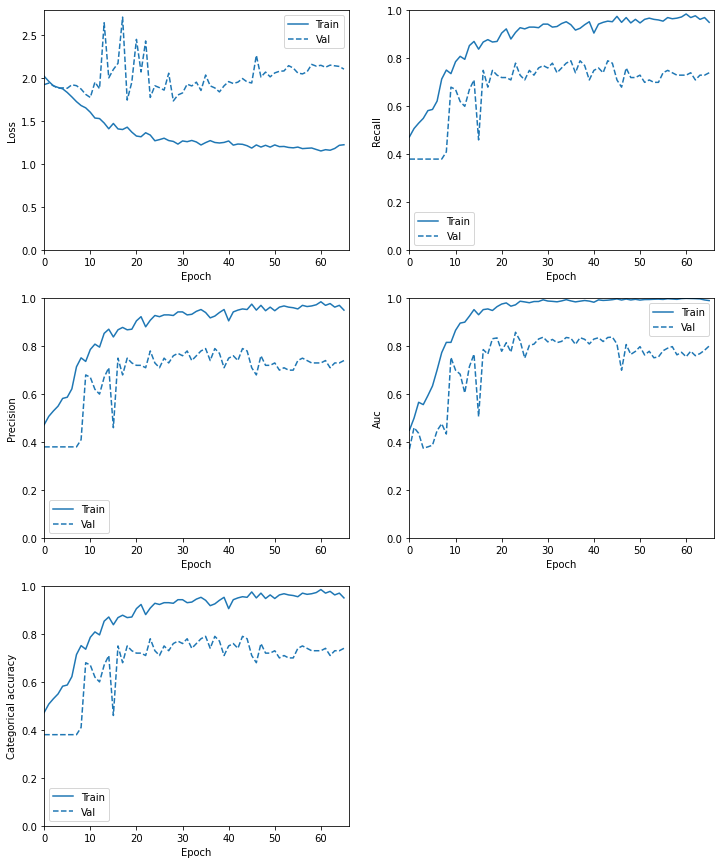

In [9]:
%%time

plot_training_history(history)

In [10]:
%%time

show_simple_metrics(model, test_seq)

loss: 1.88352632522583
recall: 0.7900000214576721
precision: 0.7900000214576721
auc: 0.8332000374794006
categorical_accuracy: 0.7900000214576721

Wall time: 24.1 s


In binary classification, recall of the positive class is also known as “sensitivity”; recall of the negative class is “specificity”. (https://scikit-learn.org/stable/modules/generated/sklearn.metrics.classification_report.html)
AD
precision: 0.7733333333333333
recall: 0.9354838709677419
f1-score: 0.8467153284671532
support: 62


CN
precision: 0.84
recall: 0.5526315789473685
f1-score: 0.6666666666666667
support: 38


micro avg
precision: 0.79
recall: 0.79
f1-score: 0.79
support: 100


macro avg
precision: 0.8066666666666666
recall: 0.7440577249575552
f1-score: 0.75669099756691
support: 100


weighted avg
precision: 0.7986666666666666
recall: 0.79
f1-score: 0.7782968369829684
support: 100


samples avg
precision: 0.79
recall: 0.79
f1-score: 0.79
support: 100


F1
micro: 0.79
macro: 0.75669099756691


accuracy_score: 0.79
sensitivity_score: 0.9354838709677419
specificity_score: 0.5526315789473685


Wall time: 21.5 s


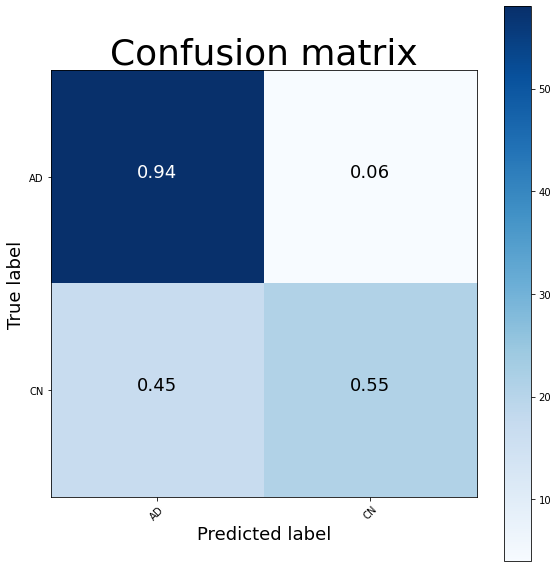

In [11]:
%%time

show_metrics(model, test_seq, class_names)